# Filter analysis of Convolutional Layers

This notebook investigates features were learned by filters in the convolutional layers in a conv. network. Especially we are interested in the features learned by filters that show a higher average activity for inputs of a certain class. In this case the network was trained on 128 electrode EEG data to discriminate between 4 classes (right hand, left hand, rest, right foot).

To find the fiters of interest the data it was trained on (1720 trials / 430 per class) was run through the network and the average activity over all units in a filter over all inputs for a certain class was recorded. The mean activity of the filters regarding a single class was then compared with the average activity for the remaining classes to find the on average most active filters for a certain class.

The 200 trials that invoked the highest response in a unit of a filter (top 46% of class trials) were determined and the signal window that was responsible for activity in that unit (receptive field of the unit on the total input) was recorded. Several features are then extracted from those windows and their distribution is compared to a baseline of (randomly) sampled control inputs also belonging to one of the 4 classes.

The deeper the layer in the convolutional network, the bigger the receptive field of its units and more complex characteristic features are expected.

In this notebook class 0 (right hand) is compared to the other classes

In [1]:
import os
cl = 0
if "EEGCLASS" in os.environ:
    cl = int(os.environ['EEGCLASS'])
max_baseline_inputs = 5000 # Number of signal windows used for baseline
wins_per_input = 3

In [2]:
import numpy as np
import scipy
import random

import logging
log = logging.getLogger()
log.setLevel("DEBUG")
from braindecode.scripts.train_experiments import setup_logging
setup_logging()

from braindecode.veganlasagne.layer_util import print_layers

import os
from numpy.random import RandomState

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5005)
/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

In [11]:
import convvisual.receptive_field.receptive_field as receptive_field
import convvisual.analysis.analysis as analysis
import convvisual.analysis as utils

In [12]:
modelpath = '/home/hartmank/braindecode/data/models/'
modelname = 'paper/ours/cnt/deep4/car/22'
savepath  = '/home/hartmank/data/convvisual/RF_data/'
RF_save = receptive_field.ReceptiveFieldInputsIO()

In [13]:
rng = RandomState(98787)

In [14]:
# Plotting functions
def cut_input_data(RF_data,filt,separated_channels=True,use_class_start_samples=False):
    reshape_channels = n_chans
    if separated_channels:
        reshape_channels = 1
    
    max_units_in_filters = np.asarray(RF_data.results[cl].max_units_in_filters)
    filt_input_indeces = max_units_in_filters[:,1]==filt
    max_units_in_filters = max_units_in_filters[filt_input_indeces]
    
    X_RF_cropped = utils.get_cropped_RF(RF_data.results[cl].RF_X[filt_input_indeces].squeeze(),([0],reshape_channels,-1))
    window_indeces = np.unique(max_units_in_filters[:,2])
    
    classes = RF_data.classes
    neg_classes = np.delete(classes,cl)
    inputs_baseline = np.array([])
    for c in neg_classes:
        inputs_baseline = np.vstack([inputs_baseline,RF_data.results[c].inputs]) if inputs_baseline.size else RF_data.results[c].inputs
        
    print inputs_baseline.shape
    if use_class_start_samples:
        X_baseline = utils.cut_ind_windows(inputs_baseline,X_RF_cropped.shape[2],window_indeces,wins_per_input=wins_per_input).squeeze()
    else:
        X_baseline = utils.cut_rand_windows(inputs_baseline,X_RF_cropped.shape[2],wins_per_input).squeeze()
    
    if separated_channels:
        X_baseline = X_baseline.reshape((-1,X_RF_cropped.shape[1],X_RF_cropped.shape[2]))
    print X_baseline.shape
    indx = rng.permutation(len(X_baseline))[:max_baseline_inputs]
    X_baseline = X_baseline[indx]
    
    return X_RF_cropped,X_baseline 
    

def plot_max_filters(RF_data):
    print 'Max filters: ',RF_data.results[cl].max_filters
    plt.figure()
    sns.heatmap(np.reshape(RF_data.results[cl].filters_means,(-1,1)).T,
                linewidths=.5)
    plt.xlabel('Filter #')
    plt.ylabel('Activation Diff')
    plt.title('Mean activation for feature maps over all inputs')
    plt.show()
    
    
def print_features(score,p,labels,indeces):
    for idx in indeces:
        print 'Score %f  p %f  : %s'%(score[idx],p[idx],labels[idx])
        
        
def plot_RF_starts(RF_data,win_size):
    plt.figure()
    max_units_in_filters = np.asarray(RF_data.results[cl].max_units_in_filters)
    max_units_in_filters = max_units_in_filters[max_units_in_filters[:,1]==filt]
    sns.distplot(max_units_in_filters[:,2],bins=np.arange(0,RF_data.results[cl].inputs.shape[2],20),kde=False)
    plt.xlim([1,RF_data.results[cl].inputs.shape[2]-win_size])
    plt.xlabel('Sample #')
    plt.ylabel('Number of receptive fields starting at sample')
    plt.title('Starting of the RF windows in complete input signal')
    plt.show()
    
    
def plot_channels(RF_data,sensor_names):
    max_units_in_filters = np.asarray(RF_data.results[cl].max_units_in_filters)
    max_units_in_filters = max_units_in_filters[max_units_in_filters[:,1]==filt]
    chan_counts = np.bincount(max_units_in_filters[:,3])
    max_chan = chan_counts.argmax()
    max_name = sensor_names[max_chan]
    plt.figure(figsize=(10, 10))
    sns.distplot(max_units_in_filters[:,3],bins=np.arange(n_chans),kde=False)
    plt.xlim([0,n_chans])
    plt.ylabel('Number of times signal window originated in channel')
    plt.xlabel('Channel')
    plt.title('Channels that provided maximized input %s: %d'%(max_name,chan_counts[max_chan]))
    plt.xticks(range(1,len(sensor_names)+1),sensor_names,rotation=90,fontsize=5)
    plt.show()
        
        
def plot_channel_avg(X_RF_cropped,channel,title=''):
    plt.figure()
    sns.tsplot(data=X_RF_cropped[:,channel],err_style="unit_points")
    m = X_RF_cropped[:,channel].mean(axis=0)
    s = X_RF_cropped[:,channel].std(axis=0)
    plt.fill_between(np.arange(X_RF_cropped.shape[2]),m-s,m+s,color='r',zorder=100,alpha=0.3) 
    plt.plot(np.arange(X_RF_cropped.shape[2]),m,color='r',zorder=101) 
    plt.xlabel('Sample # (250Hz)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.show()
    

def plot_channel_avg_comparison(X1,X2,channel):
    plt.figure()
    #sns.tsplot(data=X_RF_cropped[:,channel],err_style="unit_traces")
    sns.tsplot(data=X1[:,channel],err_style="unit_traces")
    sns.tsplot(data=X2[:,channel],err_style="unit_traces")
    plt.show()
    
    
def plot_dist_comparison(features,features_base,idx):
    sns.distplot(features[:,idx],label='Input')
    sns.distplot(features_base[:,idx],label='Baseline')
    plt.legend()
    plt.xlabel(labels[idx])
    plt.show()
    
    
def subplots_4_features(features,features_base,indeces):
    plt.figure()
    plt.subplot(221)
    plot_dist_comparison(features,features_base,indeces[0])
    plt.subplot(222)
    plot_dist_comparison(features,features_base,indeces[1])
    plt.subplot(223)
    plot_dist_comparison(features,features_base,indeces[2])
    plt.subplot(224)
    plot_dist_comparison(features,features_base,indeces[3])
    
    
def plot_phaselocks(phaselocks,sensor_names):
    plt.figure(figsize=(30, 30))
    sns.heatmap(phaselocks,xticklabels=sensor_names,yticklabels=sensor_names)
    plt.plot([0, len(sensor_names)],[len(sensor_names), 0])
    plt.show()

# Layer 03

Analysis of filters in Layer 03

In [17]:
filename = 'Layer03_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_03 = RF_save.load(os.path.join(savepath,modelname,filename))

ImportError: No module named receptive_field

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

In [ ]:
plot_max_filters(RF_data_03)

<b>Filter to look at</b> (index in Max filters)

In [10]:
filt = 0

In [11]:
n_chans = RF_data_03.results[cl].n_chans
sampling_rate = RF_data_03.results[cl].sampling_rate
sensor_names = RF_data_03.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_03,filt,separated_channels=True)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

sensor_names_one_chan = ['N/A' for entry in sensor_names]
feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names_one_chan,frequencies],
                                    'FFTc':[sensor_names_one_chan,frequencies],
                                    'Phase':[sensor_names_one_chan,frequencies[1:]],
                                    'Phasec':[sensor_names_one_chan,frequencies[1:]],
                                    'Mean':[sensor_names_one_chan],
                                    'Meanc':[sensor_names_one_chan],
                                    'Bandpower':[sensor_names_one_chan]})

(1342, 128, 1000, 1)


utils.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  tmp = inputs[i,:,ind_start[i,j]:ind_end[i,j]]


(17177600, 1, 10)
(200, 1, 5)
(200, 1, 1)
(5000, 1, 5)
(5000, 1, 1)


/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [12]:
print X_RF_cropped.shape

(200, 1, 10)


### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

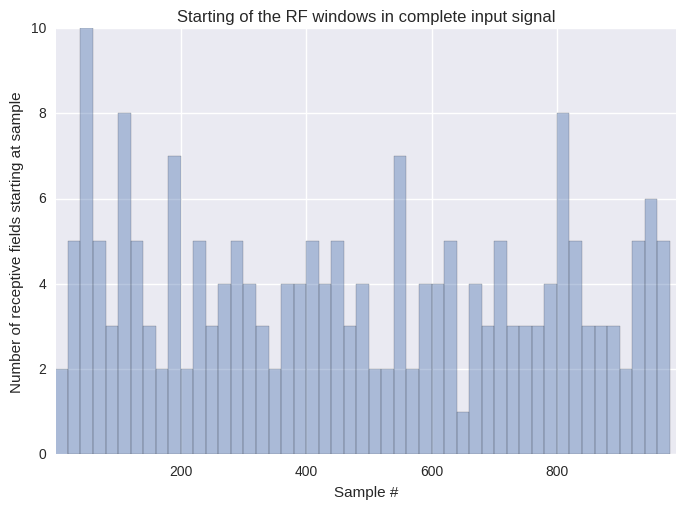

In [13]:
plot_RF_starts(RF_data_03,X_baseline.shape[2])

### Channels of the Receptive Field
In Layer 03 the receptive field is still channel specific. Therefore it could be interesting to see from which channel the most maximizing signal windows originate

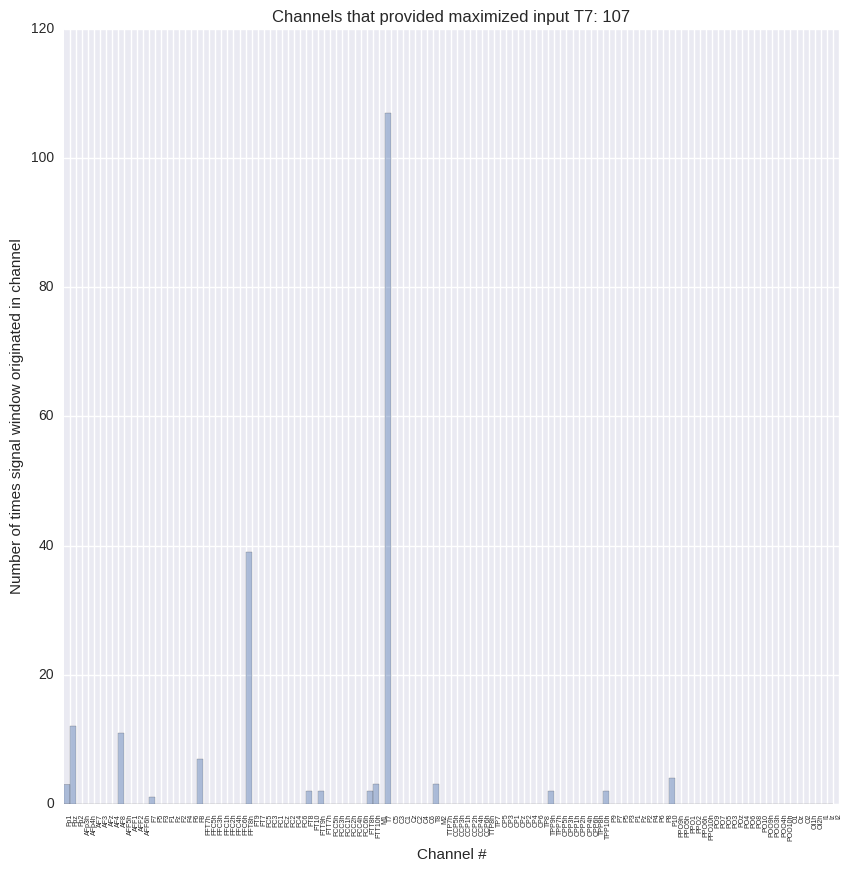

In [93]:
plot_channels(RF_data_03,sensor_names)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

There are no channel specific features in L03, because the features are extracted for the one channel in the receptive field.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [15]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.983000  p 0.000000  : FFT N/A 75.0
Score 0.969000  p 0.000000  : FFT N/A 50.0
Score 0.957400  p 0.000000  : FFT N/A 100.0
Score 0.826600  p 0.000000  : FFT N/A 25.0
Score 0.690800  p 0.000000  : FFTc N/A 25.0
Score 0.602800  p 0.000000  : Phase N/A 25.0
Score 0.596600  p 0.000000  : Phase N/A 75.0
Score 0.522600  p 0.000000  : Phase N/A 100.0
Score 0.455600  p 0.000000  : Phase N/A 50.0
Score 0.267200  p 0.000000  : Phasec N/A 25.0
Score 0.209000  p 0.000000  : FFTc N/A 0.0
Score 0.167200  p 0.000035  : Mean N/A
Score 0.077000  p 0.195842  : FFT N/A 0.0
Score 0.000000  p 1.000000  : PhaseLock N/A
Score 0.000000  p 1.000000  : Meanc N/A


##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

(200, 15) (5000, 15)


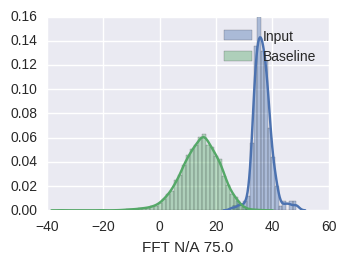

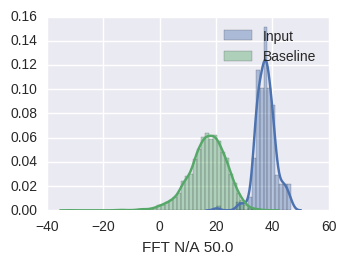

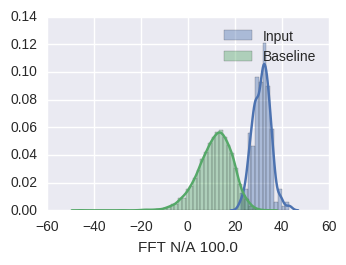

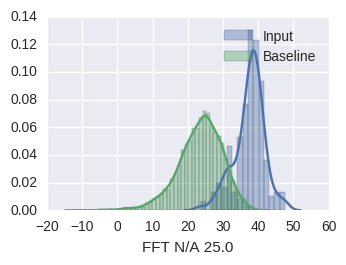

In [16]:
print features_class.shape,features_base.shape
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

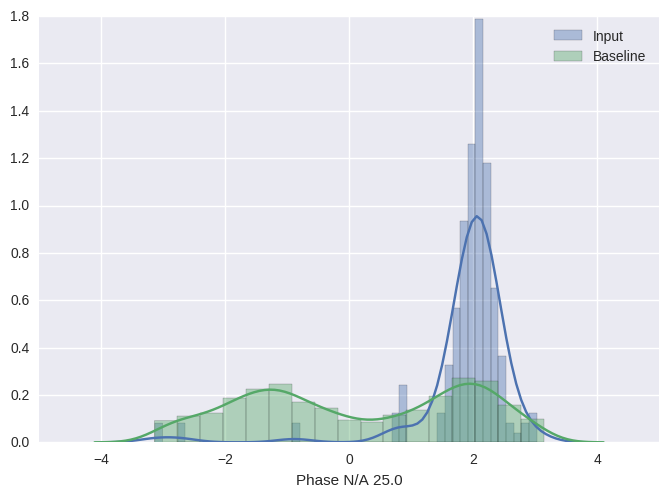

In [17]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[5])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows.  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [18]:
print index_labels[sort_mean_diff[:10]]

[['FFT', [0, 3]] ['FFT', [0, 2]] ['FFT', [0, 4]] ['FFT', [0, 1]]
 ['FFTc', [0, 1]] ['Phase', [0, 0]] ['Phase', [0, 2]] ['Phase', [0, 3]]
 ['Phase', [0, 1]] ['Phasec', [0, 0]]]


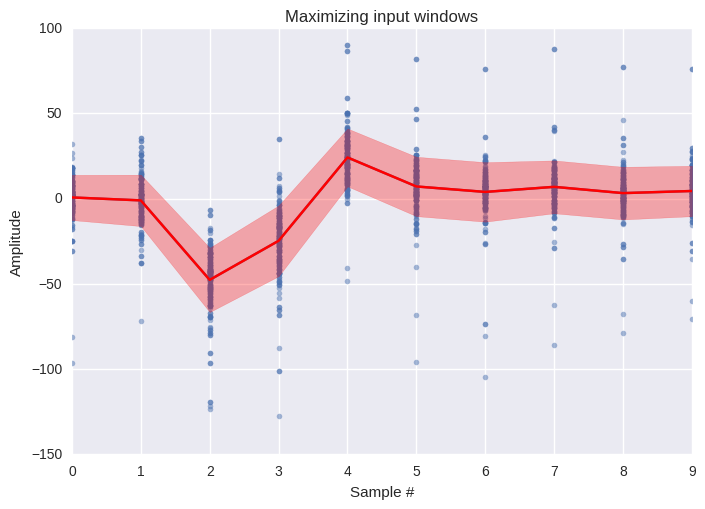

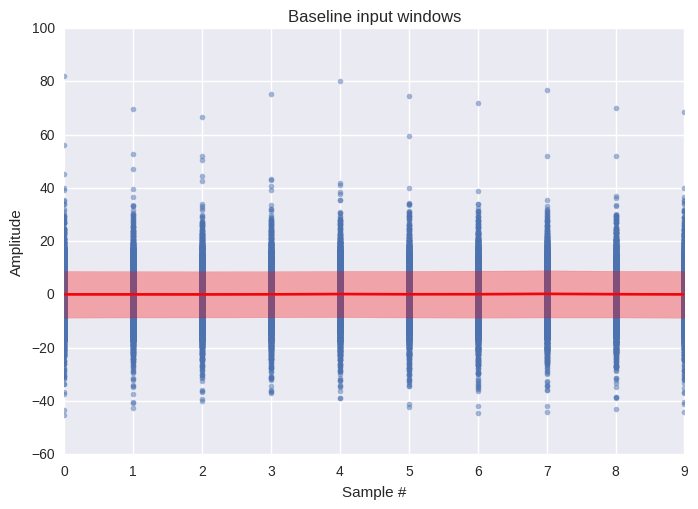

In [19]:
plot_channel_avg(X_RF_cropped,0,'Maximizing input windows')
plot_channel_avg(X_baseline,0,'Baseline input windows')

# Layer 04

Analysis of filters in Layer 04

In [20]:
del RF_data_03

In [9]:
filename = 'Layer04_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_04 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [24 12 20 13 14]


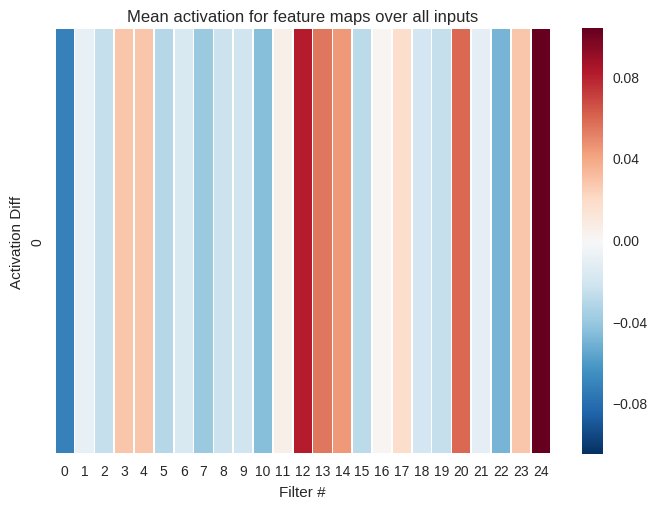

In [10]:
plot_max_filters(RF_data_04)

<b>Filter to look at</b> (index in Max filters)

In [11]:
filt = 0

In [51]:
n_chans = RF_data_04.results[cl].n_chans
sampling_rate = RF_data_04.results[cl].sampling_rate
sensor_names = RF_data_04.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_04,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Bandpower':[sensor_names]})

(1342, 128, 1000, 1)


utils.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  tmp = inputs[i,:,ind_start[i,j]:ind_end[i,j]]


(134200, 128, 10)
(200, 128, 5) (200, 128) (200, 128, 1) (200, 128)
(1000, 128, 5) (1000, 128) (1000, 128, 1) (1000, 128)


### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

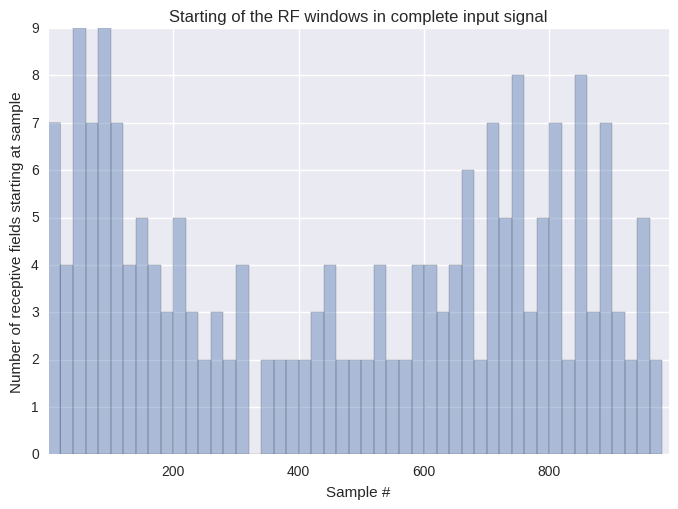

In [52]:
plot_RF_starts(RF_data_04,X_baseline.shape[2])

### Phase locking of channels
Phase locking of channel pairs. Phase locking is computed for class signals and baseline signals. The plot shows the difference PL_class-PL_baseline. The Phase locking value is averaged over the complete windows. So an average Phase locking for all inputs and time steps is computed.
http://www.ncbi.nlm.nih.gov/pubmed/10619414

The Phase Lock Values are computed for the band 8-15 Hz

In [94]:
phaselock_class = analysis.phase_locking_value(X_RF_cropped, sampling_rate, 100, [8, 15])
phaselock_base = analysis.phase_locking_value(X_baseline, sampling_rate, 100, [8, 15])
plot_phaselocks(phaselock_class-phaselock_base,sensor_names)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [53]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.703000  p 0.000000  : Meanc CPz
Score 0.692000  p 0.000000  : Meanc CCP2h
Score 0.671000  p 0.000000  : Meanc CCP1h
Score 0.650000  p 0.000000  : Meanc Cz
Score 0.639000  p 0.000000  : Meanc CPP1h
Score 0.628000  p 0.000000  : Phase CCP1h 100.0
Score 0.624000  p 0.000000  : Phase CPz 100.0
Score 0.623000  p 0.000000  : FFT CPz 75.0
Score 0.616000  p 0.000000  : Phase Cz 100.0
Score 0.614000  p 0.000000  : Meanc CP4
Score 0.613000  p 0.000000  : Phase CCP1h 50.0
Score 0.612000  p 0.000000  : Phase Cz 50.0
Score 0.609000  p 0.000000  : Meanc CP1
Score 0.606000  p 0.000000  : Meanc CPP2h
Score 0.603000  p 0.000000  : FFT CPz 50.0
Score 0.601000  p 0.000000  : Phase CPz 50.0
Score 0.594000  p 0.000000  : Bandpower CPz
Score 0.593000  p 0.000000  : Bandpower CCP2h
Score 0.591000  p 0.000000  : FFT CPz 100.0
Score 0.591000  p 0.000000  : Phase CCP2h 50.0


##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

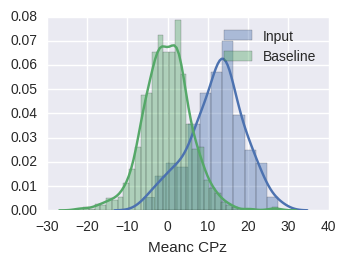

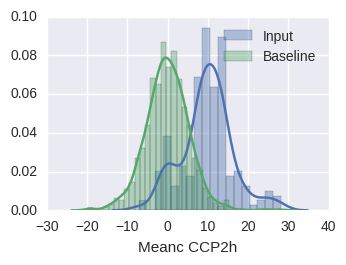

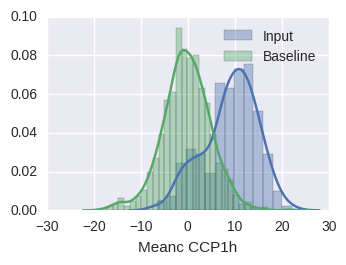

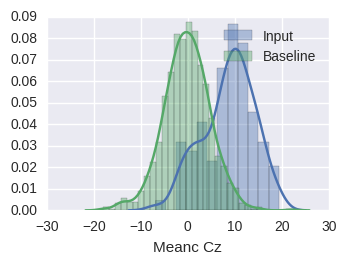

In [54]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

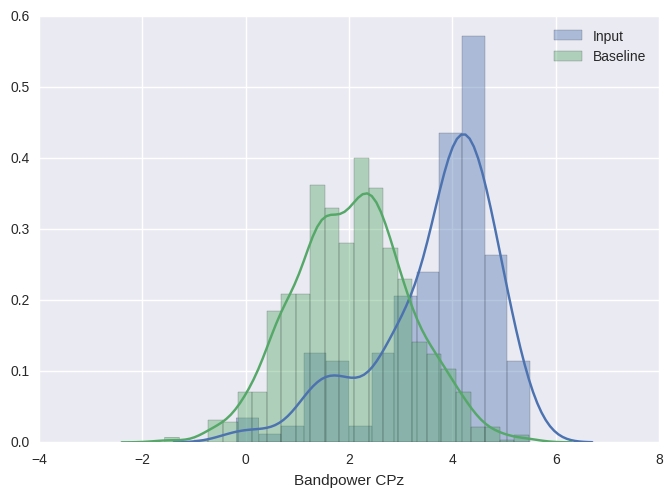

In [55]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[16])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [29]:
print index_labels[sort_mean_diff[:10]]

[['FFT', [75, 3]] ['Phase', [75, 3]] ['Phase', [66, 3]] ['FFT', [75, 2]]
 ['Phase', [57, 3]] ['FFT', [75, 4]] ['Phase', [75, 1]] ['Phase', [84, 0]]
 ['Phase', [57, 1]] ['FFT', [66, 3]]]


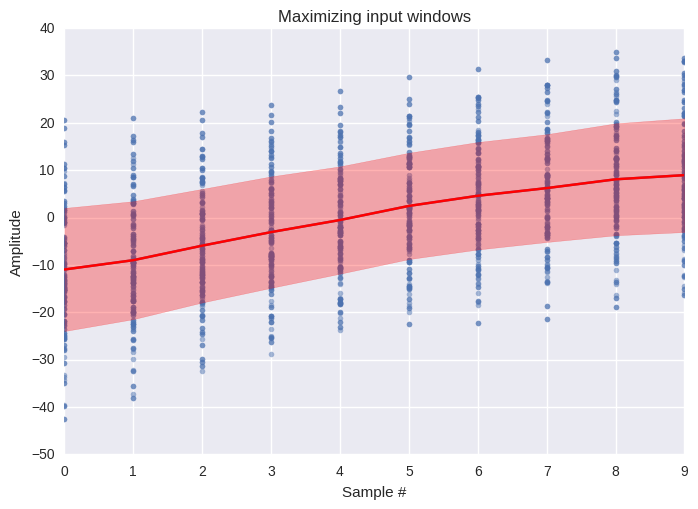

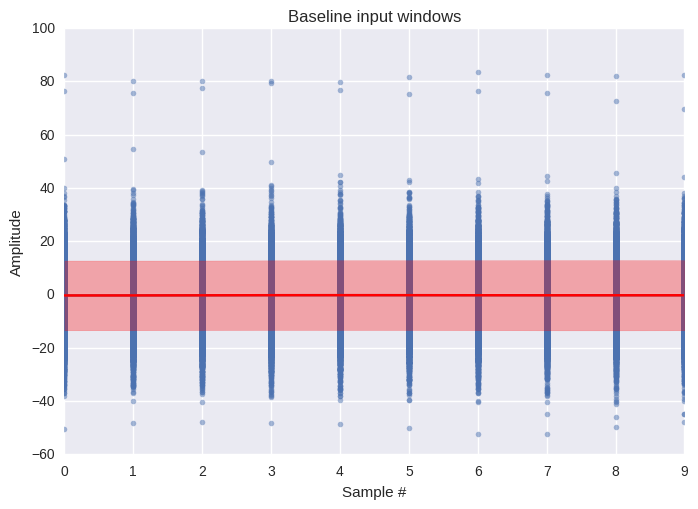

In [30]:
plot_channel_avg(X_RF_cropped,75,'Maximizing input windows')
plot_channel_avg(X_baseline,75,'Baseline input windows')

# Layer 10

Analysis of filters in Layer 10

In [31]:
del RF_data_04

In [32]:
filename = 'Layer10_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_10 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [25 49 16 27 11]


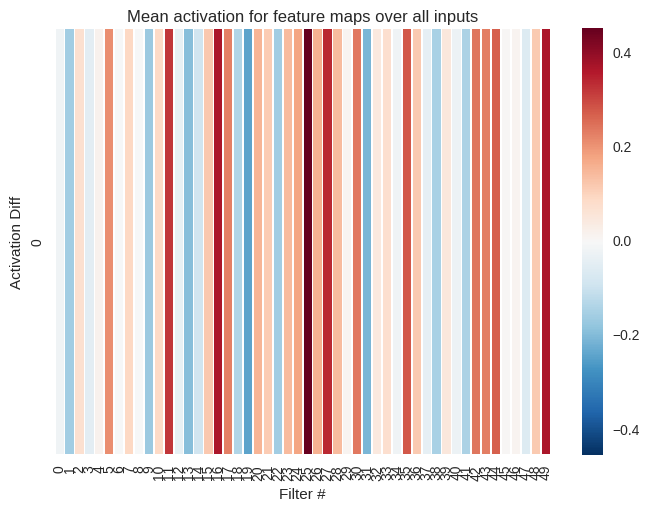

In [33]:
plot_max_filters(RF_data_10)

<b>Filter to look at</b> (index in Max filters)

In [34]:
filt = 0

In [35]:
n_chans = RF_data_10.results[cl].n_chans
sampling_rate = RF_data_10.results[cl].sampling_rate
sensor_names = RF_data_10.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_10,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Bandpower':[sensor_names]})

(1342, 128, 1000, 1)
(134200, 128, 39)
(200, 128, 18)
(200, 128, 8)
(5000, 128, 18)
(5000, 128, 8)


### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

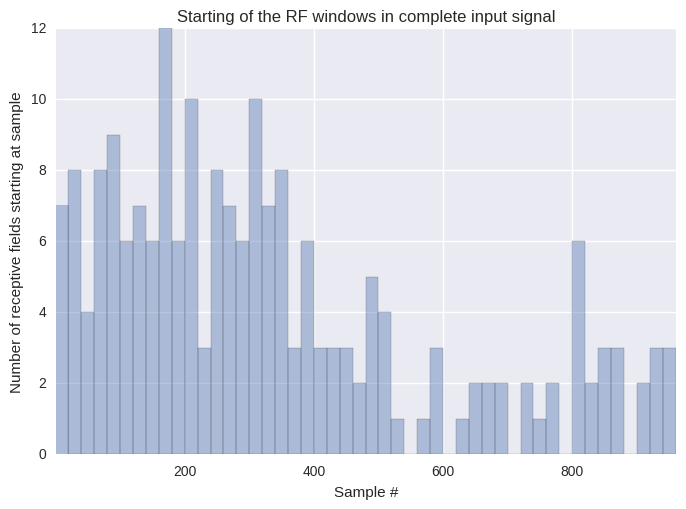

In [36]:
plot_RF_starts(RF_data_10,X_baseline.shape[2])

### Phase locking of channels
Phase locking of channel pairs. Phase locking is computed for class signals and baseline signals. The plot shows the difference PL_class-PL_baseline. The Phase locking value is averaged over the complete windows. So an average Phase locking for all inputs and time steps is computed.
http://www.ncbi.nlm.nih.gov/pubmed/10619414

The Phase Lock Values are computed for the band 8-15 Hz

In [94]:
phaselock_class = analysis.phase_locking_value(X_RF_cropped, sampling_rate, 100, [8, 15])
phaselock_base = analysis.phase_locking_value(X_baseline, sampling_rate, 100, [8, 15])
plot_phaselocks(phaselock_class-phaselock_base,sensor_names)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [37]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.499000  p 0.000000  : FFT FCC4h 12.8205128205
Score 0.446000  p 0.000000  : FFT FC4 12.8205128205
Score 0.417600  p 0.000000  : Phase CCP5h 12.8205128205
Score 0.415200  p 0.000000  : Phase TTP7h 12.8205128205
Score 0.411400  p 0.000000  : Phase FCC4h 12.8205128205
Score 0.409800  p 0.000000  : Phase C5 12.8205128205
Score 0.399200  p 0.000000  : Phase CP5 12.8205128205
Score 0.389800  p 0.000000  : Phase FC4 12.8205128205
Score 0.384200  p 0.000000  : FFT FCC2h 12.8205128205
Score 0.384000  p 0.000000  : Phase C4 12.8205128205
Score 0.380400  p 0.000000  : FFT FC2 12.8205128205
Score 0.378000  p 0.000000  : Phase C2 12.8205128205
Score 0.377200  p 0.000000  : Phase CCP4h 12.8205128205
Score 0.358600  p 0.000000  : FFT C2 12.8205128205
Score 0.355600  p 0.000000  : Phase FT7 12.8205128205
Score 0.347600  p 0.000000  : Phase TP7 12.8205128205
Score 0.333400  p 0.000000  : Phase FTT7h 12.8205128205
Score 0.332200  p 0.000000  : Phase FC2 12.8205128205
Score 0.330800  p 0.000000  

##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

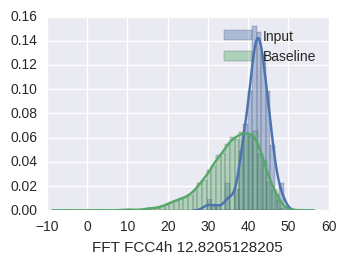

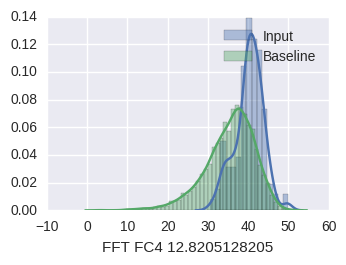

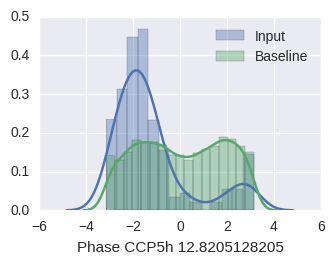

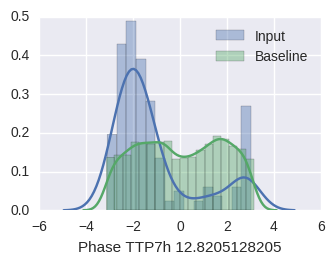

In [38]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

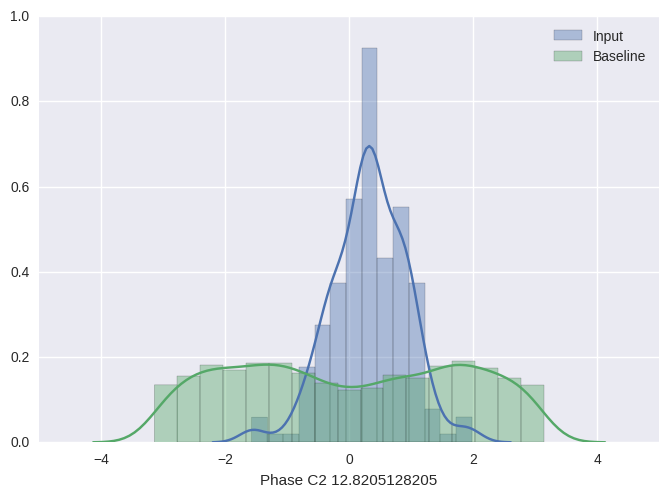

In [39]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[11])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [40]:
print index_labels[sort_mean_diff[:10]]

[['FFT', [48, 2]] ['FFT', [38, 2]] ['Phase', [64, 1]] ['Phase', [63, 1]]
 ['Phase', [48, 1]] ['Phase', [54, 1]] ['Phase', [72, 1]]
 ['Phase', [38, 1]] ['FFT', [47, 2]] ['Phase', [59, 1]]]


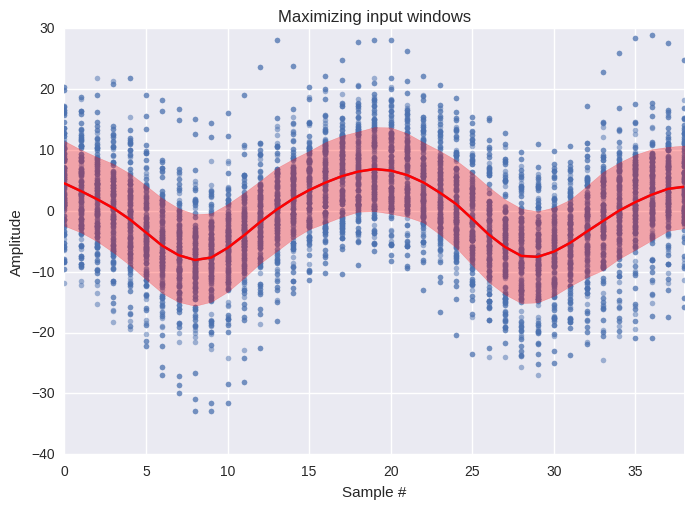

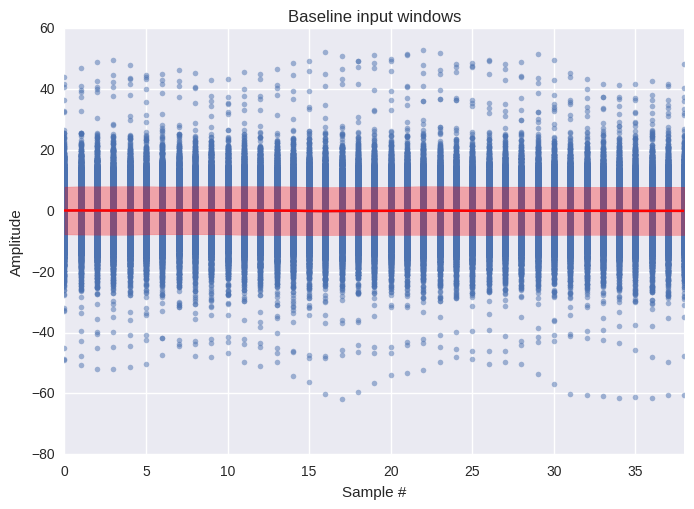

In [41]:
plot_channel_avg(X_RF_cropped,48,'Maximizing input windows')
plot_channel_avg(X_baseline,48,'Baseline input windows')

# Layer 16

Analysis of filters in Layer 16

In [42]:
del RF_data_10

In [43]:
filename = 'Layer16_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_16 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [70 62 76 55 88]


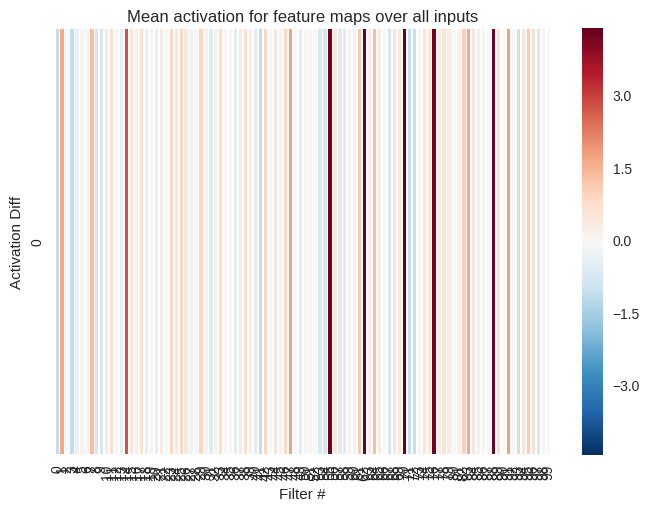

In [44]:
plot_max_filters(RF_data_16)

<b>Filter to look at</b> (index in Max filters)

In [45]:
filt = 0

In [46]:
n_chans = RF_data_16.results[cl].n_chans
sampling_rate = RF_data_16.results[cl].sampling_rate
sensor_names = RF_data_16.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_16,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Bandpower':[sensor_names]})

(1342, 128, 1000, 1)
(134200, 128, 126)
(200, 128, 63)
(200, 128, 30)
(5000, 128, 63)
(5000, 128, 30)


### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

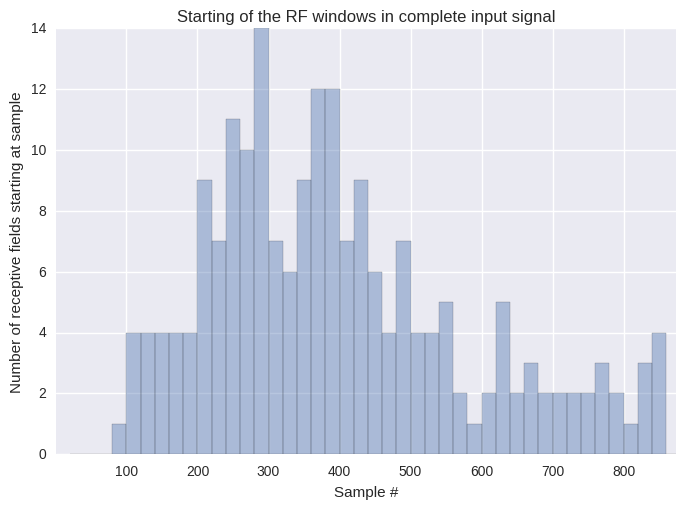

In [47]:
plot_RF_starts(RF_data_16,X_baseline.shape[2])

### Phase locking of channels
Phase locking of channel pairs. Phase locking is computed for class signals and baseline signals. The plot shows the difference PL_class-PL_baseline. The Phase locking value is averaged over the complete windows. So an average Phase locking for all inputs and time steps is computed.
http://www.ncbi.nlm.nih.gov/pubmed/10619414

The Phase Lock Values are computed for the band 8-15 Hz

In [94]:
phaselock_class = analysis.phase_locking_value(X_RF_cropped, sampling_rate, 100, [8, 15])
phaselock_base = analysis.phase_locking_value(X_baseline, sampling_rate, 100, [8, 15])
plot_phaselocks(phaselock_class-phaselock_base,sensor_names)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [48]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.731600  p 0.000000  : Phase FCC4h 11.9047619048
Score 0.641600  p 0.000000  : Phase FC4 11.9047619048
Score 0.609200  p 0.000000  : FFT C3 11.9047619048
Score 0.564000  p 0.000000  : Phase C4 11.9047619048
Score 0.520400  p 0.000000  : FFT CCP3h 11.9047619048
Score 0.516600  p 0.000000  : Phase C2 11.9047619048
Score 0.512800  p 0.000000  : Phase FFC4h 11.9047619048
Score 0.498200  p 0.000000  : FFT FCC3h 11.9047619048
Score 0.497400  p 0.000000  : Phase FC2 11.9047619048
Score 0.480400  p 0.000000  : FFT CCP5h 11.9047619048
Score 0.477800  p 0.000000  : FFT FC3 11.9047619048
Score 0.470800  p 0.000000  : Phase FCC2h 11.9047619048
Score 0.452600  p 0.000000  : Phase FCC6h 11.9047619048
Score 0.446000  p 0.000000  : Phase CCP4h 11.9047619048
Score 0.433600  p 0.000000  : FFT CP3 11.9047619048
Score 0.417800  p 0.000000  : Phase FFC6h 11.9047619048
Score 0.416000  p 0.000000  : FFT C1 11.9047619048
Score 0.413400  p 0.000000  : Phase CCP6h 11.9047619048
Score 0.404000  p 0.000000

##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

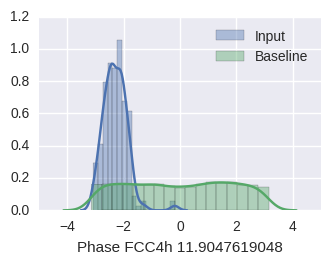

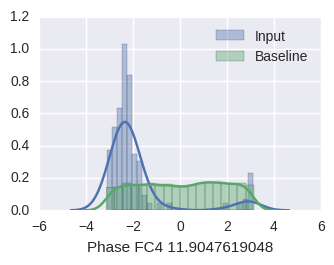

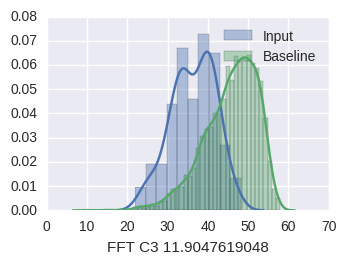

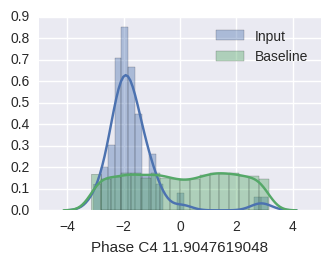

In [49]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

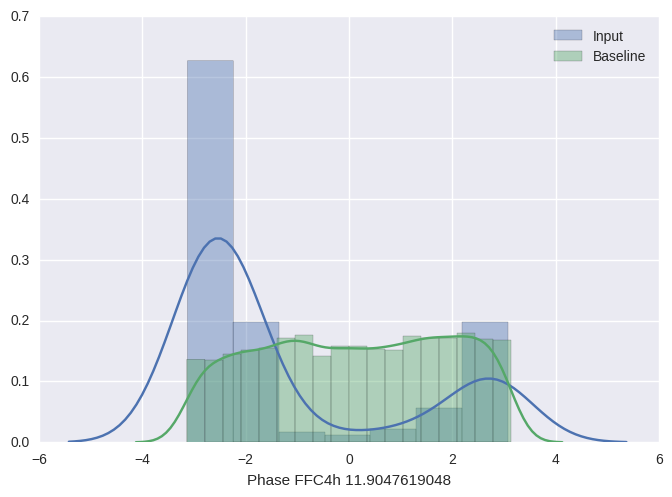

In [50]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[6])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [51]:
print index_labels[sort_mean_diff[:10]]

[['Phase', [48, 5]] ['Phase', [38, 5]] ['FFT', [55, 6]] ['Phase', [59, 5]]
 ['FFT', [65, 6]] ['Phase', [58, 5]] ['Phase', [28, 5]] ['FFT', [45, 6]]
 ['Phase', [37, 5]] ['FFT', [64, 6]]]


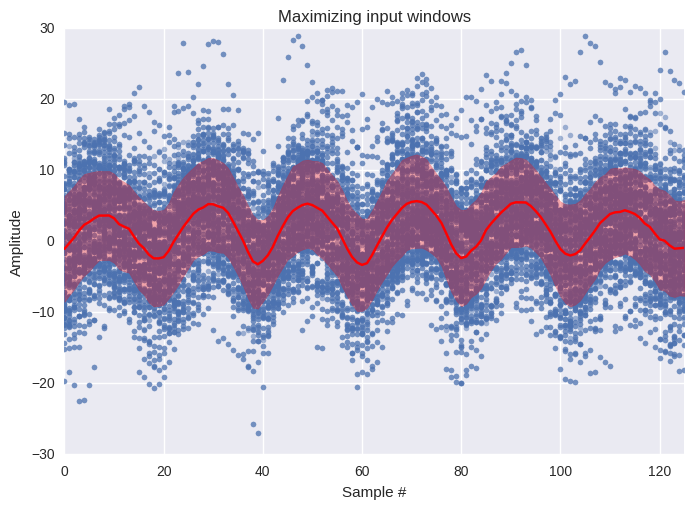

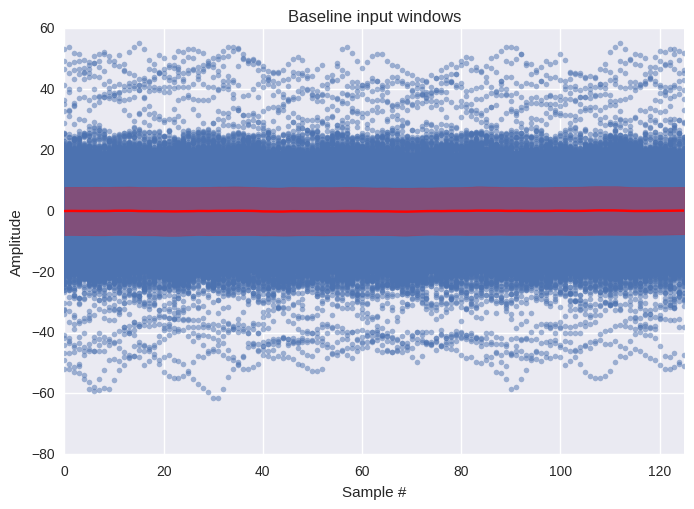

In [52]:
plot_channel_avg(X_RF_cropped,48,'Maximizing input windows')
plot_channel_avg(X_baseline,48,'Baseline input windows')

# Layer 22

Analysis of filters in Layer 22

In [53]:
del RF_data_16

In [54]:
filename = 'Layer22_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_22 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [155  70  85   7 183]


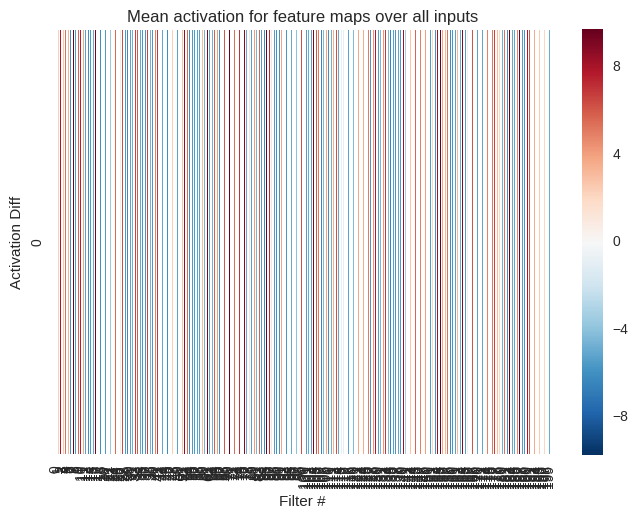

In [55]:
plot_max_filters(RF_data_22)

<b>Filter to look at</b> (index in Max filters)

In [56]:
filt = 0

In [57]:
n_chans = RF_data_22.results[cl].n_chans
sampling_rate = RF_data_22.results[cl].sampling_rate
sensor_names = RF_data_22.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_22,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Bandpower':[sensor_names]})

(1342, 128, 1000, 1)
(134200, 128, 387)
(200, 128, 192)
(200, 128, 95)
(5000, 128, 192)
(5000, 128, 95)


### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

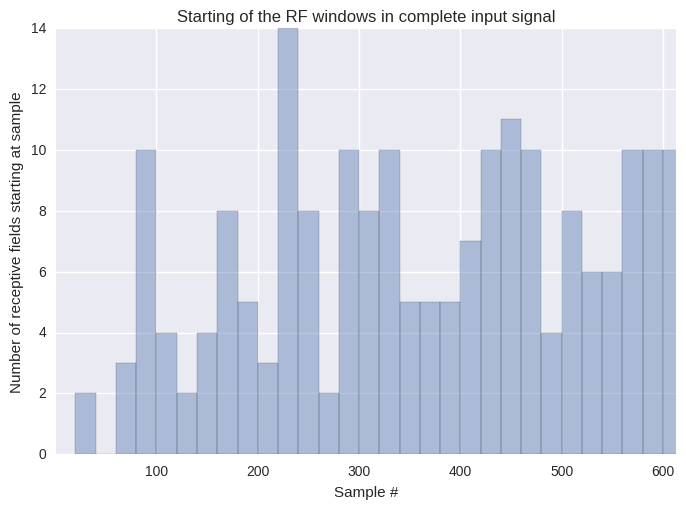

In [58]:
plot_RF_starts(RF_data_22,X_baseline.shape[2])

### Phase locking of channels
Phase locking of channel pairs. Phase locking is computed for class signals and baseline signals. The plot shows the difference PL_class-PL_baseline. The Phase locking value is averaged over the complete windows. So an average Phase locking for all inputs and time steps is computed.
http://www.ncbi.nlm.nih.gov/pubmed/10619414

The Phase Lock Values are computed for the band 8-15 Hz

In [94]:
phaselock_class = analysis.phase_locking_value(X_RF_cropped, sampling_rate, 100, [8, 15])
phaselock_base = analysis.phase_locking_value(X_baseline, sampling_rate, 100, [8, 15])
plot_phaselocks(phaselock_class-phaselock_base,sensor_names)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [59]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.621200  p 0.000000  : FFT C3 11.6279069767
Score 0.570000  p 0.000000  : FFT CCP3h 11.6279069767
Score 0.551600  p 0.000000  : FFT FCC3h 11.6279069767
Score 0.550800  p 0.000000  : FFT CCP5h 11.6279069767
Score 0.541800  p 0.000000  : FFT CP3 11.6279069767
Score 0.534000  p 0.000000  : FFT C3 10.9819121447
Score 0.533200  p 0.000000  : FFT C3 12.2739018088
Score 0.521600  p 0.000000  : FFT FC3 11.6279069767
Score 0.481800  p 0.000000  : FFT C4 10.9819121447
Score 0.457200  p 0.000000  : FFT CCP3h 12.2739018088
Score 0.455400  p 0.000000  : FFT CCP5h 10.9819121447
Score 0.448600  p 0.000000  : FFT CP5 11.6279069767
Score 0.438800  p 0.000000  : FFT FCC4h 10.9819121447
Score 0.438000  p 0.000000  : FFT C3 22.6098191214
Score 0.436800  p 0.000000  : FFT C1 11.6279069767
Score 0.432600  p 0.000000  : FFT C3 23.2558139535
Score 0.427600  p 0.000000  : FFT C3 9.68992248062
Score 0.406400  p 0.000000  : FFT FCC5h 11.6279069767
Score 0.404600  p 0.000000  : FFT CP3 12.2739018088
Score 

##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

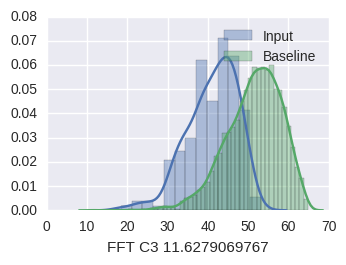

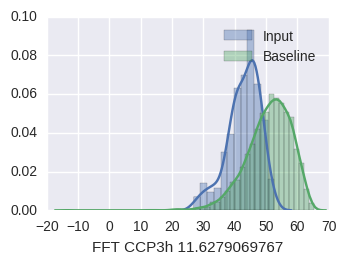

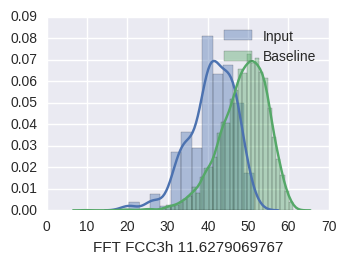

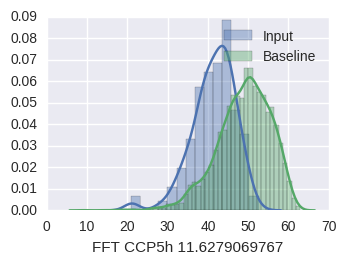

In [60]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

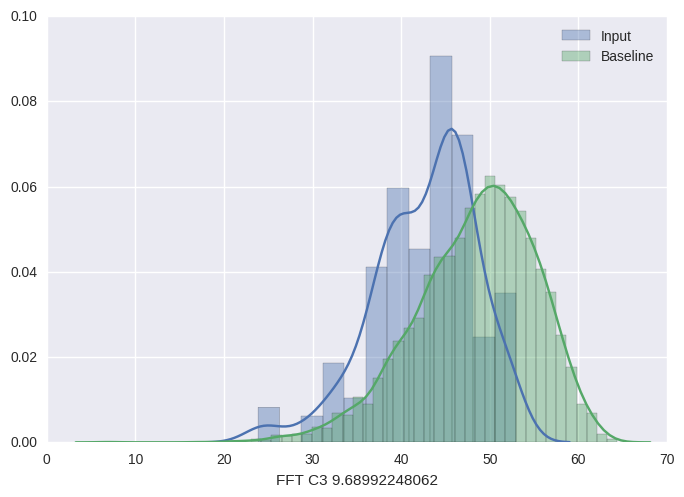

In [61]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[16])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [62]:
print index_labels[sort_mean_diff[:10]]

[['FFT', [55, 18]] ['FFT', [65, 18]] ['FFT', [45, 18]] ['FFT', [64, 18]]
 ['FFT', [73, 18]] ['FFT', [55, 17]] ['FFT', [55, 19]] ['FFT', [34, 18]]
 ['FFT', [59, 17]] ['FFT', [65, 19]]]


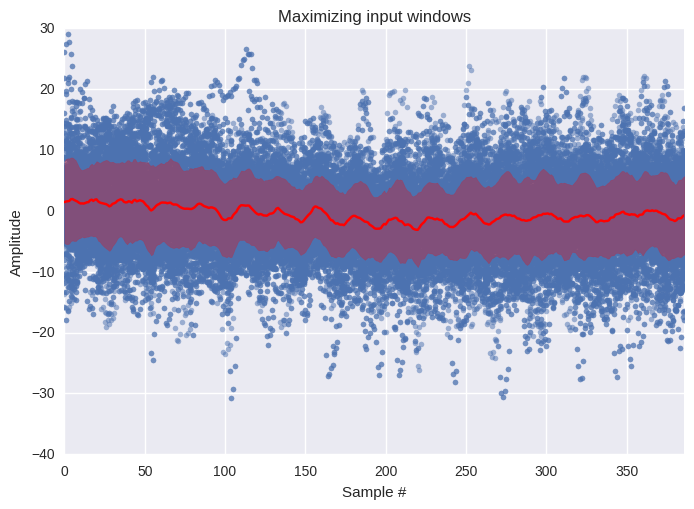

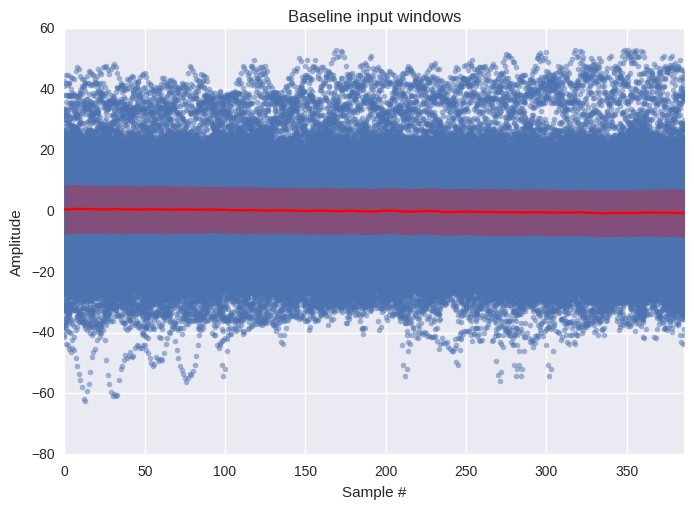

In [63]:
plot_channel_avg(X_RF_cropped,55,'Maximizing input windows')
plot_channel_avg(X_baseline,55,'Baseline input windows')

# Layer 28

Analysis of filters in Layer 28

In [64]:
RF_data_22

<receptive_field.ReceptiveFieldInputsIO instance at 0x7f61cfb91f80>

In [65]:
filename = 'Layer28_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_28 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [0 1 2 3]


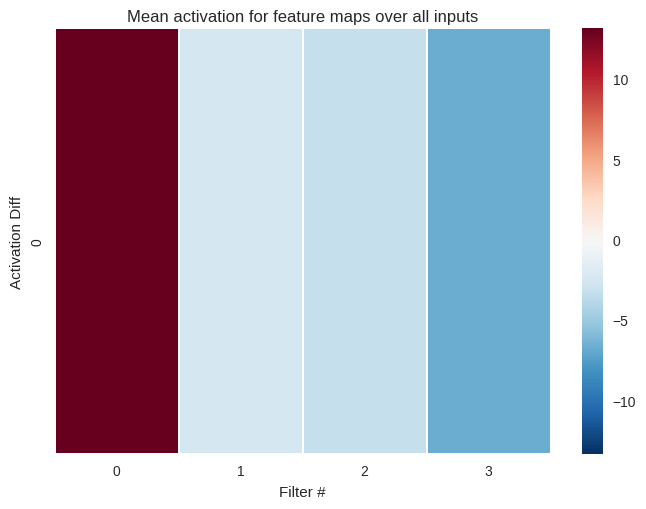

In [66]:
plot_max_filters(RF_data_28)

<b>Filter to look at</b> (index in Max filters)

In [67]:
filt = 0

In [68]:
n_chans = RF_data_28.results[cl].n_chans
sampling_rate = RF_data_28.results[cl].sampling_rate
sensor_names = RF_data_28.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_28,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Bandpower':[sensor_names]})

(1342, 128, 1000, 1)
(134200, 128, 522)
(316, 128, 261)
(316, 128, 129)
(5000, 128, 261)
(5000, 128, 129)


### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

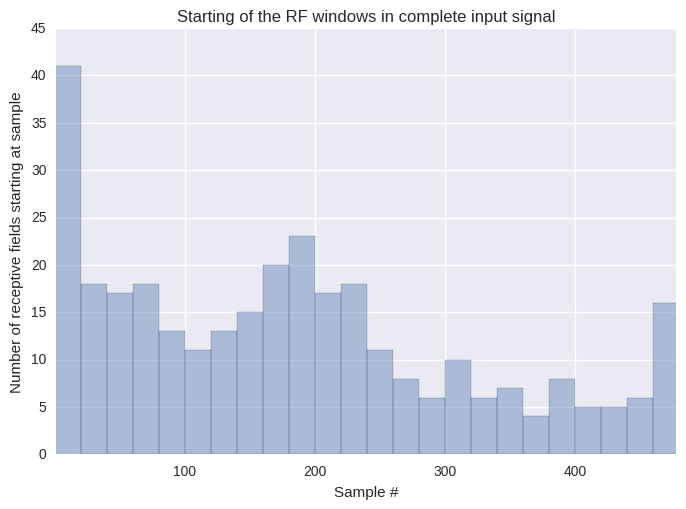

In [69]:
plot_RF_starts(RF_data_28,X_baseline.shape[2])

### Phase locking of channels
Phase locking of channel pairs. Phase locking is computed for class signals and baseline signals. The plot shows the difference PL_class-PL_baseline. The Phase locking value is averaged over the complete windows. So an average Phase locking for all inputs and time steps is computed.
http://www.ncbi.nlm.nih.gov/pubmed/10619414

The Phase Lock Values are computed for the band 8-15 Hz

In [94]:
phaselock_class = analysis.phase_locking_value(X_RF_cropped, sampling_rate, 100, [8, 15])
phaselock_base = analysis.phase_locking_value(X_baseline, sampling_rate, 100, [8, 15])
plot_phaselocks(phaselock_class-phaselock_base,sensor_names)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [70]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.486959  p 0.000000  : FFT C3 11.0153256705
Score 0.457716  p 0.000000  : FFT C3 11.4942528736
Score 0.452099  p 0.000000  : FFT CCP5h 11.0153256705
Score 0.452048  p 0.000000  : FFT CCP3h 11.4942528736
Score 0.433577  p 0.000000  : FFT CP3 11.4942528736
Score 0.432985  p 0.000000  : FFT CCP5h 11.4942528736
Score 0.427797  p 0.000000  : FFT CCP3h 11.0153256705
Score 0.424838  p 0.000000  : FFT C3 11.9731800766
Score 0.403208  p 0.000000  : FFT FCC3h 11.4942528736
Score 0.396572  p 0.000000  : FFT CCP3h 11.9731800766
Score 0.394208  p 0.000000  : FFT FCC3h 11.0153256705
Score 0.390808  p 0.000000  : FFT CP3 11.0153256705
Score 0.382772  p 0.000000  : FFT CP5 11.0153256705
Score 0.382527  p 0.000000  : FFT FC3 11.4942528736
Score 0.379243  p 0.000000  : FFT FC3 11.0153256705
Score 0.369078  p 0.000000  : FFT C3 10.5363984674
Score 0.366491  p 0.000000  : FFT FCC4h 11.9731800766
Score 0.365195  p 0.000000  : FFT C1 11.4942528736
Score 0.361565  p 0.000000  : FFT CP3 11.9731800766
S

##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

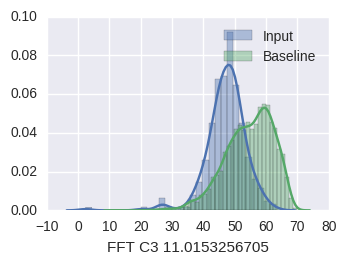

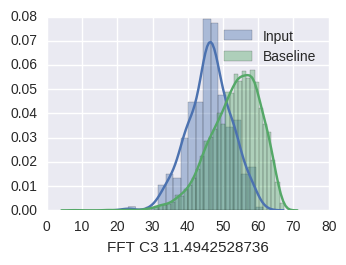

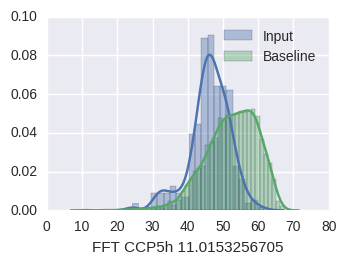

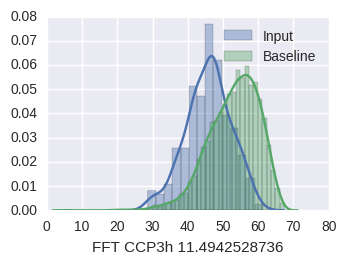

In [71]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

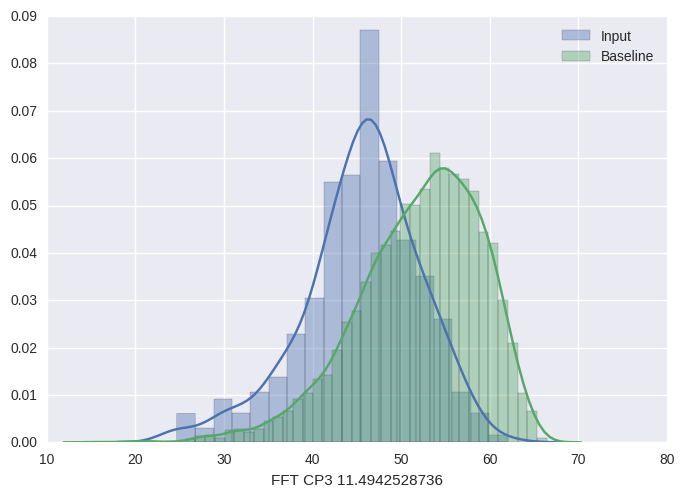

In [72]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[4])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [73]:
print index_labels[sort_mean_diff[:10]]

[['FFT', [55, 23]] ['FFT', [55, 24]] ['FFT', [64, 23]] ['FFT', [65, 24]]
 ['FFT', [73, 24]] ['FFT', [64, 24]] ['FFT', [65, 23]] ['FFT', [55, 25]]
 ['FFT', [45, 24]] ['FFT', [65, 25]]]


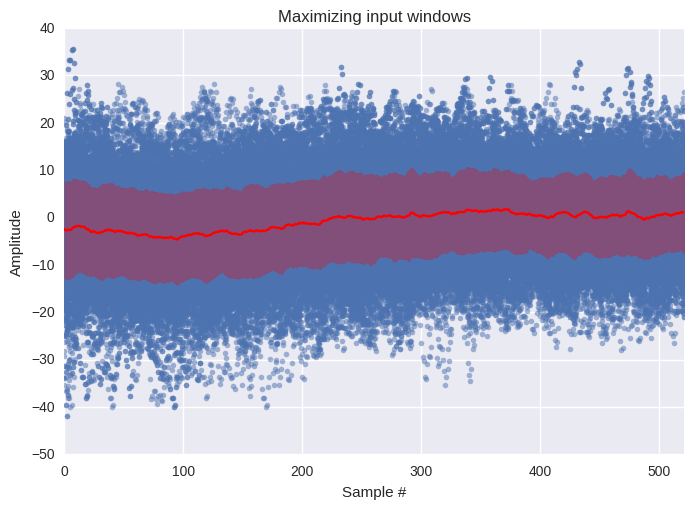

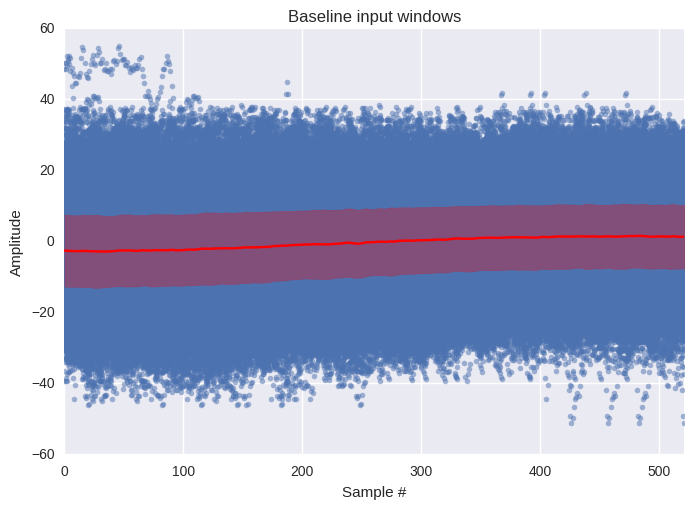

In [74]:
plot_channel_avg(X_RF_cropped,55,'Maximizing input windows')
plot_channel_avg(X_baseline,55,'Baseline input windows')